In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd
import random

warnings.filterwarnings('ignore')
print('Done..')

Done..


In [2]:
import torch

print(torch.__version__)
print('cuda : ',  torch.cuda.is_available())

2.7.1+cu118
cuda :  True


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
set_seed(42)

In [4]:
@dataclass(frozen=True)
class TraningConfig:
    batch_size: int = 32
    num_epochs: int = 32
    learning_rate: float = 1e-4
    
    log_interval: int = 1
    test_interval: int = 1
    num_workers: int = 5
    device: str = 'cuda'
    
TraningConfig = TraningConfig()
DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print('Available Device: ', DEVICE)

Available Device:  cuda


In [5]:
train_root = os.path.join('../10_Monkey_Species', 'training', 'training')
val_root = os.path.join('../10_Monkey_Species', 'validation', 'validation')

In [6]:
df = pd.read_csv('../10_Monkey_Species/monkey_labels.txt')
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [7]:
df.columns = ['label', 'Lname', 'Cname', 'train', 'val']
df

,label,Lname,Cname,train,val
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [8]:
df = df[['label', 'Cname']]
df

,label,Cname
0,n0,mantled_howler
1,n1,patas_monkey
2,n2,bald_uakari
3,n3,japanese_macaque
4,n4,pygmy_marmoset
5,n5,white_headed_capuchin
6,n6,silvery_marmoset
7,n7,common_squirrel_monkey
8,n8,black_headed_night_monkey
9,n9,nilgiri_langur


In [9]:
df.label.values

array(['n0   ', 'n1   ', 'n2   ', 'n3   ', 'n4   ', 'n5   ', 'n6   ',
       'n7   ', 'n8   ', 'n9   '], dtype=object)

In [10]:
df.label = df.label.str.strip()
df.Cname = df.Cname.str.strip()

labels = df['label'].values
names = df.Cname.values

class_map = {i:v for i, (k, v) in enumerate(zip(labels, names))}

class_map

{0: 'mantled_howler',
 1: 'patas_monkey',
 2: 'bald_uakari',
 3: 'japanese_macaque',
 4: 'pygmy_marmoset',
 5: 'white_headed_capuchin',
 6: 'silvery_marmoset',
 7: 'common_squirrel_monkey',
 8: 'black_headed_night_monkey',
 9: 'nilgiri_langur'}

In [11]:
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

img_size = (224, 224)
preprocess = transforms.Compose([
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor()
])

In [12]:
common_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean=mean, std=std)
])

train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    transforms.RandomErasing(p=0.4),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
         ], p =0.1),
    transforms.Normalize(mean=mean, std=std)
])

In [13]:
train_data = datasets.ImageFolder(root=train_root, transform=train_transforms)
train_data

Dataset ImageFolder
    Number of datapoints: 1097
    Root location: ../10_Monkey_Species\training\training
    StandardTransform
Transform: Compose(
                 Compose(
                   Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=True)
                   ToTensor()
             )
                 RandomHorizontalFlip(p=0.5)
                 RandomErasing(p=0.4, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=[0.0], inplace=False)
                 RandomApply(    RandomAffine(degrees=[30.0, 70.0], translate=(0.1, 0.3), scale=(0.5, 0.75), interpolation=InterpolationMode.NEAREST, fill=0))
                 Normalize(mean=[0.4368, 0.4336, 0.3294], std=[0.2457, 0.2413, 0.2447], inplace=False)
           )

In [14]:
val_data = datasets.ImageFolder(root=val_root, transform=common_transforms)
val_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [15]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [16]:

len(train_data), len(val_data)

(1097, 272)

In [17]:
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=TraningConfig.batch_size,
    num_workers=TraningConfig.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle=True,
    batch_size=TraningConfig.batch_size,
    num_workers=TraningConfig.num_workers
)

In [18]:
len(next(iter(train_loader)))

2

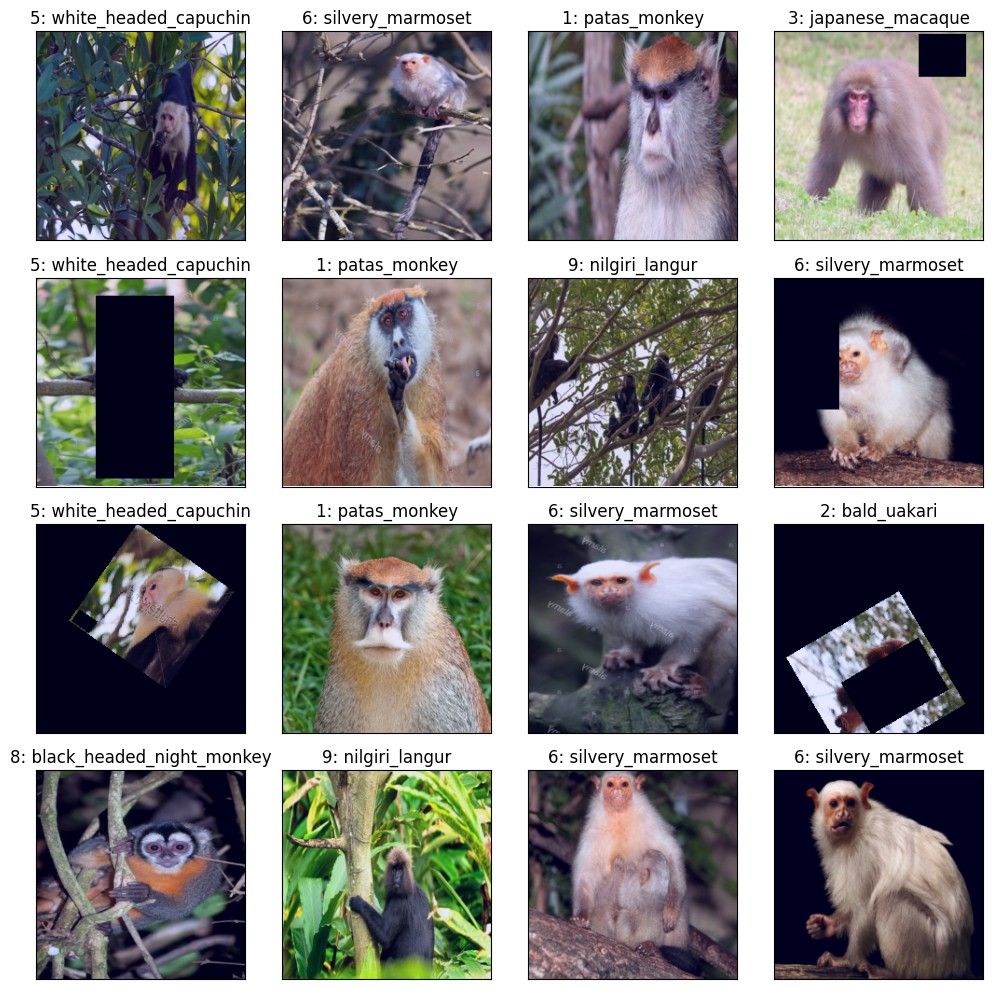

In [19]:
def visualize_images(dataloader, num_images = 20):
    fig = plt.figure(figsize=(10, 10))
    
    images, labels = next(iter(dataloader))
    
    num_rows = 4
    num_cols = int(np.ceil((num_images/ num_rows)))
    
    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        image = image.permute(1,2,0)
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap='gray')
        ax.set_title(f'{label.item()}: {class_map[label.item()]}')
    fig.tight_layout()
    plt.show()
    
visualize_images(train_loader, num_images=16)

In [20]:
class MyModel(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        self._model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.LazyConv2d(out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.LazyConv2d(out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3),
            
            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3),
            nn.MaxPool2d(2),
            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d(output_size=(3,3)),
            
            nn.Flatten(),
            
            nn.Linear(in_features=512*3*3, out_features=256),
            nn.Linear(in_features=256, out_features=10)
        )
        
    def forward(self, x):
        return self._model(x)

In [21]:
model = MyModel()

optimizer = Adam(model.parameters(), lr=TraningConfig.learning_rate)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
logdir = "runs/80epochs-3.3M_param_dropout"
writer = SummaryWriter(logdir)

dummy_input = (1,3,224,224)
print(summary(model, dummy_input, row_settings=['var_names'], device='cpu'))

Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (_model)                    [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 64, 218, 218]         18,496
│    └─BatchNorm2d (4)                   [1, 64, 218, 218]         128
│    └─ReLU (5)                          [1, 64, 218, 218]         --
│    └─Conv2d (6)                        [1, 128, 216, 216]        73,856
│    └─BatchNorm2d (7)                   [1, 128, 216, 216]        256
│    └─ReLU (8)                          [1, 128, 216, 216]        --
│    └─MaxPool2d (9)                     [1, 128, 108, 108]        --
│    └─Conv2dNormActivation (10)         [1, 256, 108, 108]        --
│ 

In [22]:
def train(model, train_loader):
    model.train()
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0
    
    for images, labels in tqdm(train_loader, desc='Traning'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()
        
    train_avg_loss = running_loss / len(val_loader)
    train_avg_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_avg_accuracy

def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)
    
    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0
    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(images)
        
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()
        
    val_avg_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_predictions / total_val_samples
    return val_avg_loss, val_accuracy

In [23]:
def main(model, train_loader, val_loader):
    train_losses, val_losses = [], []
    trains_accuracies, val_accuracies = [], []
    
    best_val_acc = 0.0
    best_weights = None
    
    # for epoch in range(TraningConfig.num_epochs):
    for epoch in range(5):
        train_loss, train_acc = train(model, train_loader)
        val_loss, val_acc = validation(model, val_loader)
        
        train_losses.append(train_loss)
        trains_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1:0>2}/{TraningConfig.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_acc)
        writer.add_scalar('Accuracy/train', val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = model.state_dict()
            print(f'Saving best model..')
            torch.save(best_weights, 'best.pt')
            
    return train_losses, trains_accuracies, val_losses, val_accuracies

In [24]:
train_losses, trains_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


Epoch 01/32 - Train Loss: 7.7075, Train Accuracy: 28.53% - Val Loss: 1.8356, Val Accuracy: 35.66%
Saving best model..


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Epoch 02/32 - Train Loss: 6.0283, Train Accuracy: 44.48% - Val Loss: 1.4039, Val Accuracy: 54.41%
Saving best model..


Validation: 100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


Epoch 03/32 - Train Loss: 4.8116, Train Accuracy: 56.88% - Val Loss: 1.2151, Val Accuracy: 56.62%
Saving best model..


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Epoch 04/32 - Train Loss: 4.3672, Train Accuracy: 61.90% - Val Loss: 1.1205, Val Accuracy: 57.35%
Saving best model..


Validation: 100%|██████████| 9/9 [00:15<00:00,  1.67s/it]

Epoch 05/32 - Train Loss: 4.2243, Train Accuracy: 63.35% - Val Loss: 1.0237, Val Accuracy: 63.60%
Saving best model..


In [27]:
train_losses

[7.707524511549208,
 6.028328471713596,
 4.811634553803338,
 4.367205944326189,
 4.224253535270691]

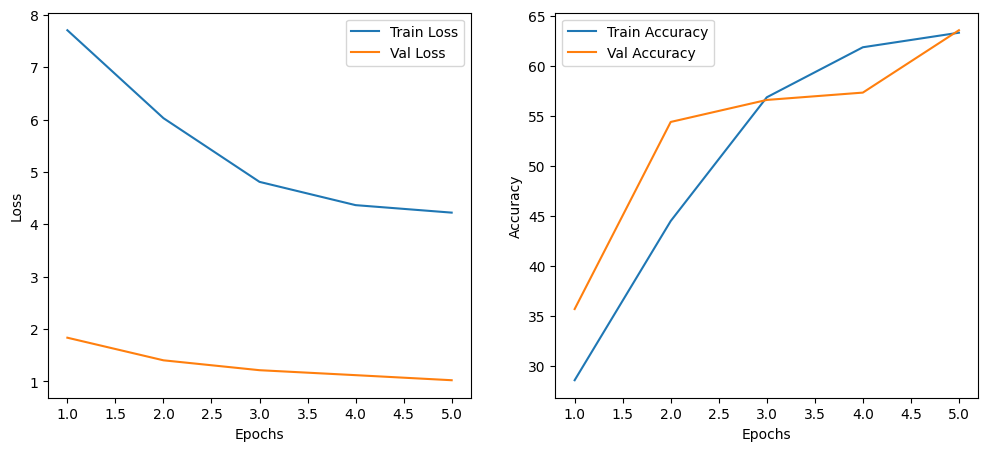

In [29]:
epochs = 5

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs + 1), trains_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
model.load_state_dict(torch.load('best063.pt'))
model.eval()

MyModel(
  (_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (11): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [48]:
def prediction(model, val_loader):
    print('*' * 100)
    model.eval()
    model.to(DEVICE)
    
    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []
    
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.inference_mode():
            outputs = model(images)
        
        prob = F.softmax(outputs, dim=1)
        print('prop shape >>', prob.shape)
        print('prop >>\n', prob)
        print('prop data >> \n\n', prob.data)
        pred_indices = prob.data.max(dim=1)[1]
        
        print('prop max len >> ', len(prob.data.max(dim=1)))
        print('prop max >> ', prob.data.max(dim=1))
        pred_probs = prob.data.max(dim=1)[0]
        
        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())
    
        print('*' * 100)
    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())
        
        

In [33]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar +mean_ar
    return np.clip(image, 0, 1)

In [34]:
def visualise_predictions(sample_images,sample_gt_labels, pred_indices, pred_probs, num_images=5):
    fig = plt.figure(figsize=(20,5))
    
    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)
        image = sample_images[idx].transpose(1,2,0)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]
        
        image = denormalize(image)
        
        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_map[label]}\nPred: {class_map[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

****************************************************************************************************
prop shape >> torch.Size([32, 10])
prop >>
 tensor([[3.0515e-04, 6.4029e-02, 1.8883e-04, 4.9426e-01, 8.6113e-03, 3.8534e-03,
         4.1173e-01, 6.6374e-03, 7.1590e-03, 3.2213e-03],
        [3.3902e-03, 2.6496e-04, 2.2670e-03, 1.3897e-03, 5.2122e-01, 2.2654e-03,
         8.1417e-03, 4.4860e-03, 4.5522e-01, 1.3615e-03],
        [6.7489e-04, 2.3475e-02, 1.1870e-03, 5.3885e-01, 7.8826e-02, 4.5770e-03,
         7.4791e-02, 4.4711e-02, 2.1905e-01, 1.3855e-02],
        [3.4293e-05, 2.0892e-01, 1.2404e-04, 5.4371e-01, 4.0584e-02, 1.8979e-03,
         1.7229e-01, 1.7420e-02, 1.4338e-02, 6.8688e-04],
        [4.9525e-04, 8.5155e-03, 1.2629e-02, 5.6657e-02, 1.4529e-02, 4.5985e-03,
         8.9452e-01, 3.9825e-03, 3.7077e-03, 3.6205e-04],
        [2.2945e-02, 1.0182e-03, 2.7715e-01, 1.9447e-03, 5.3576e-02, 5.8833e-03,
         1.6236e-02, 1.0928e-02, 6.0939e-01, 9.3579e-04],
        [1.0416e-05, 

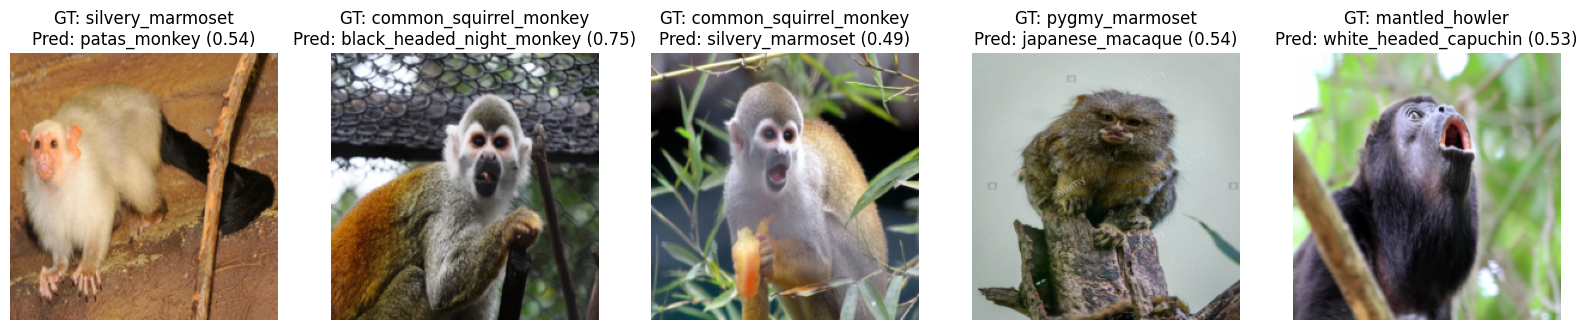

In [49]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

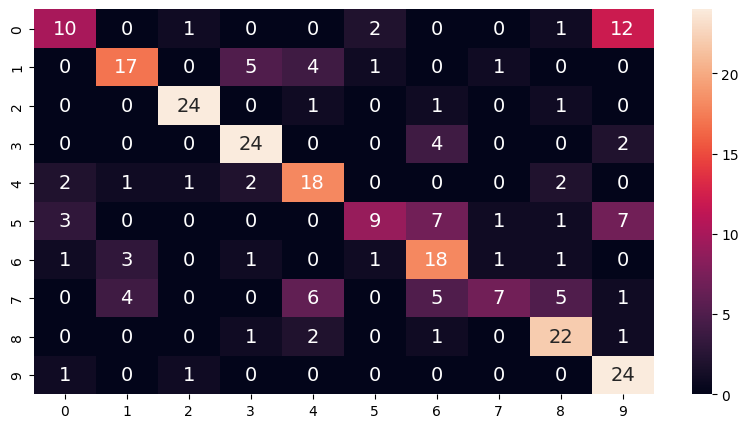

In [50]:
cm = confusion_matrix(y_true=val_gt_labels, y_pred=pred_indices)

plt.figure(figsize=(10,5))
sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 14})
plt.show()